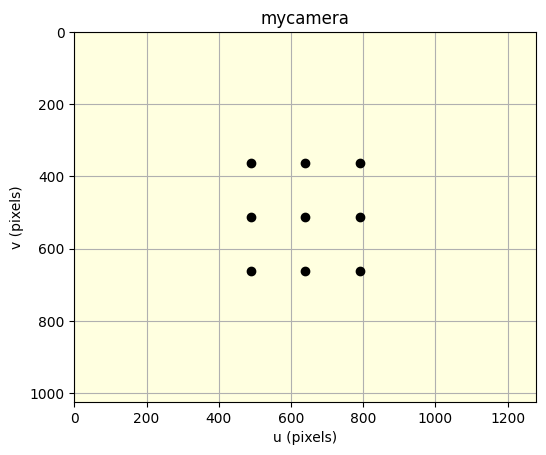

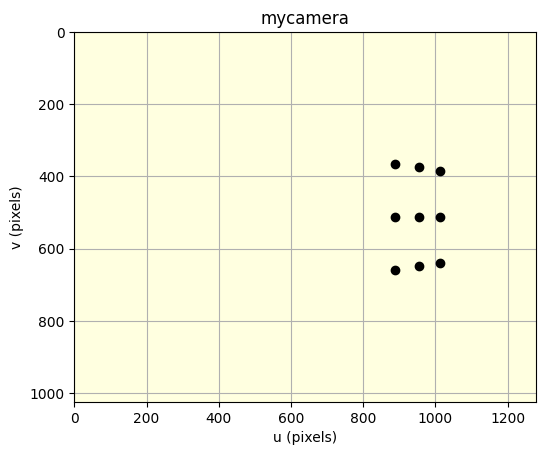

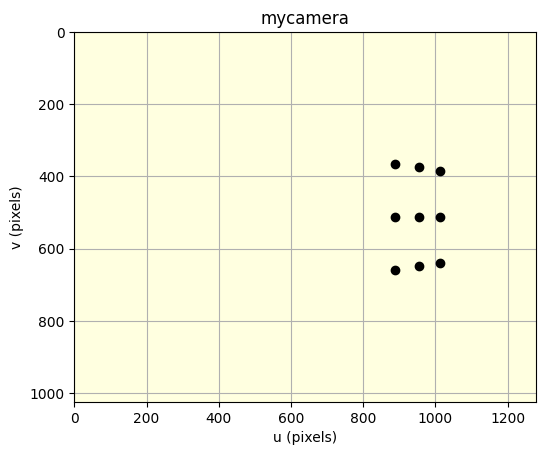

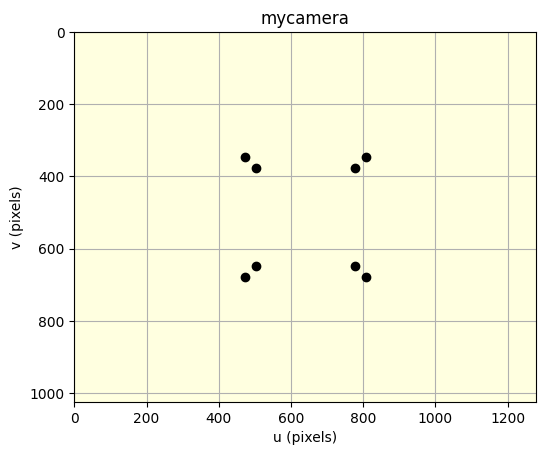

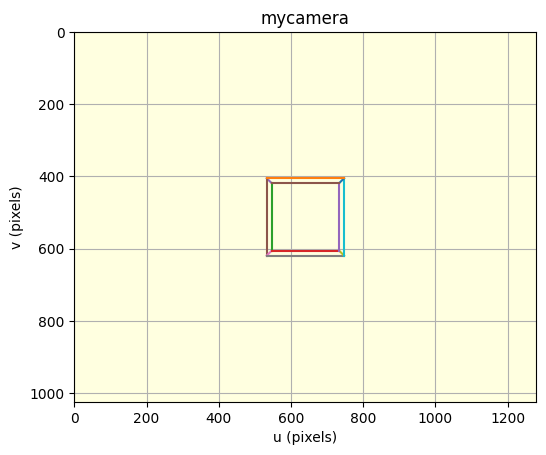

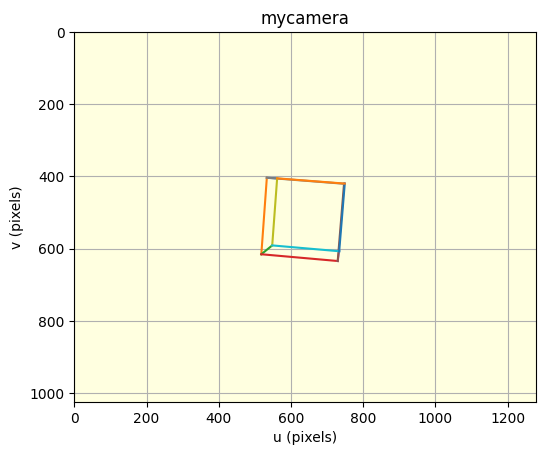

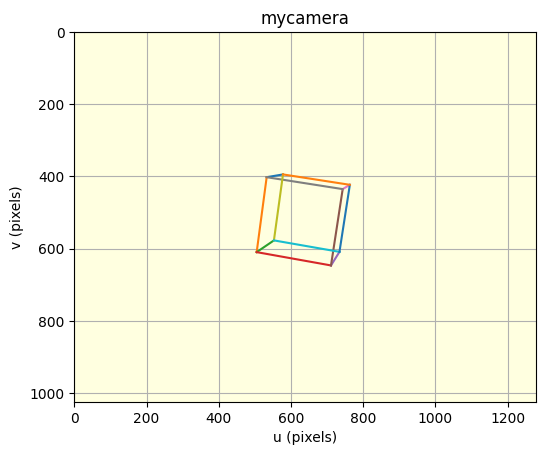

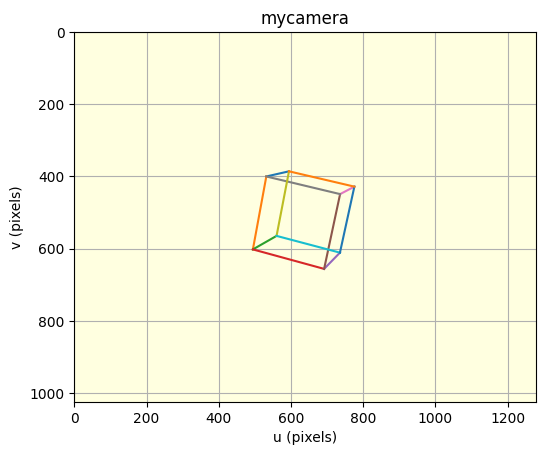

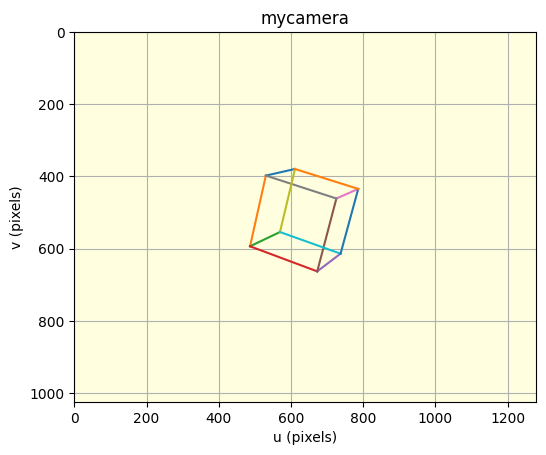

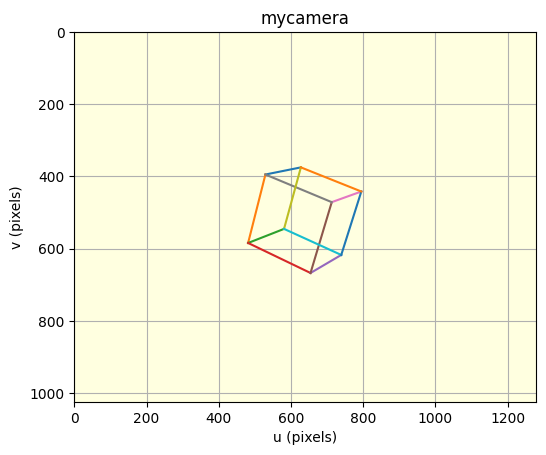

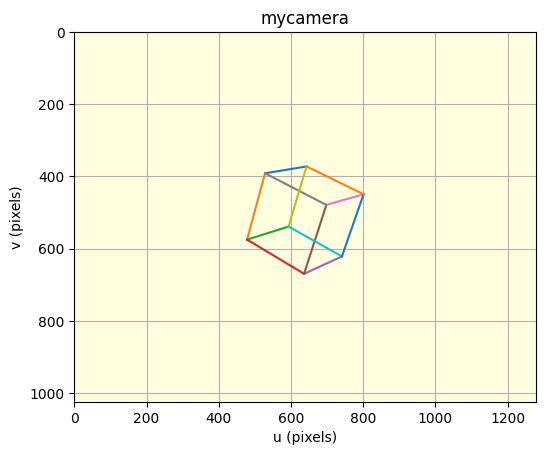

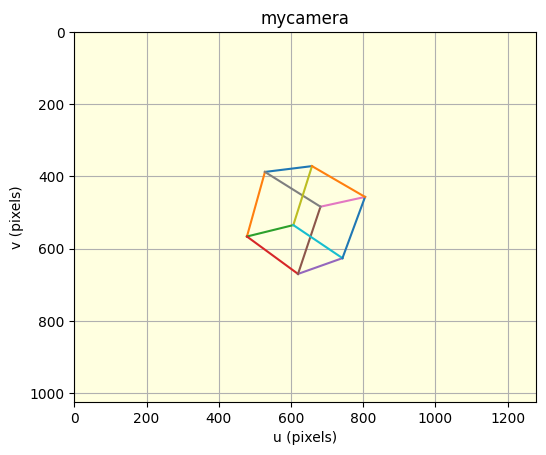

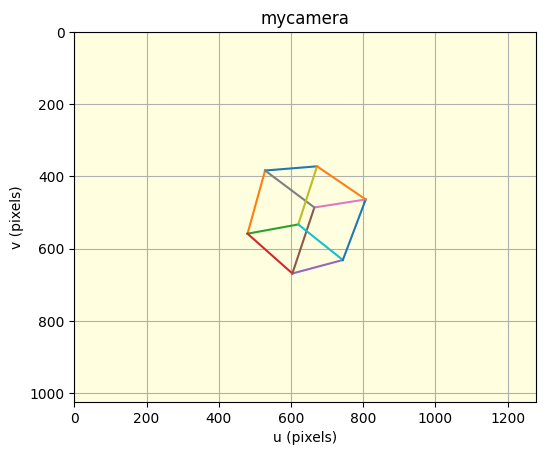

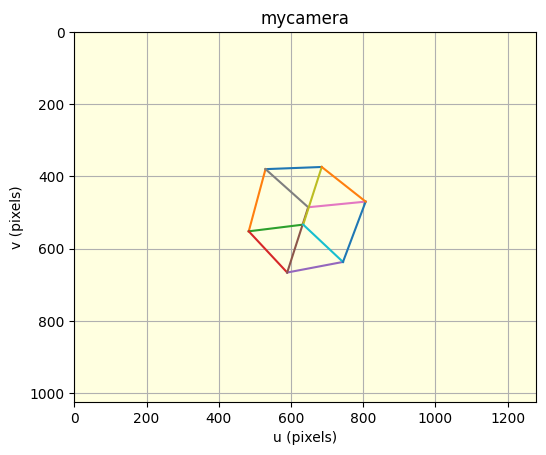

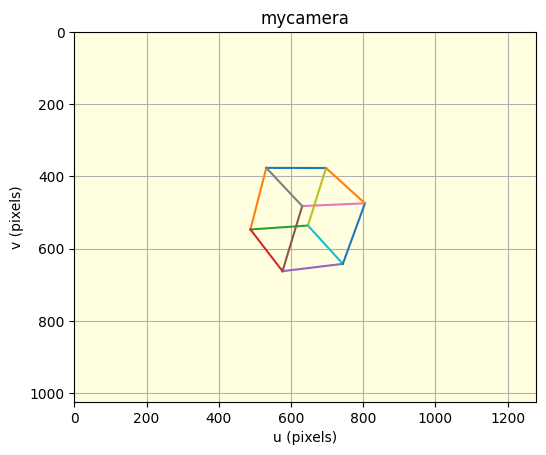

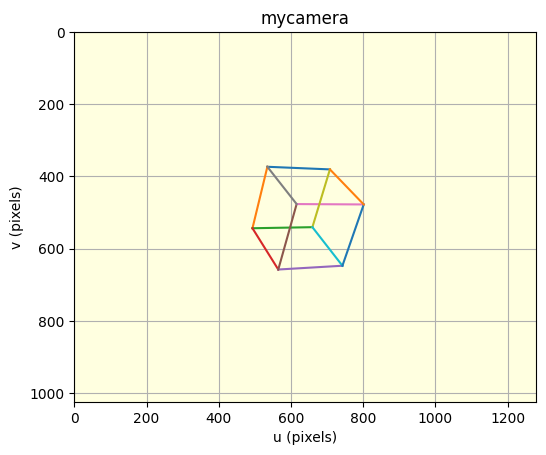

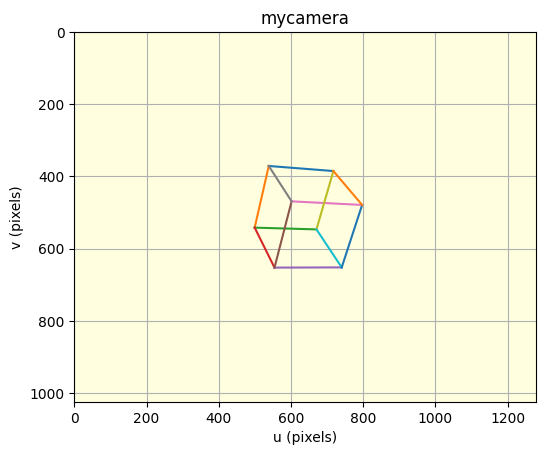

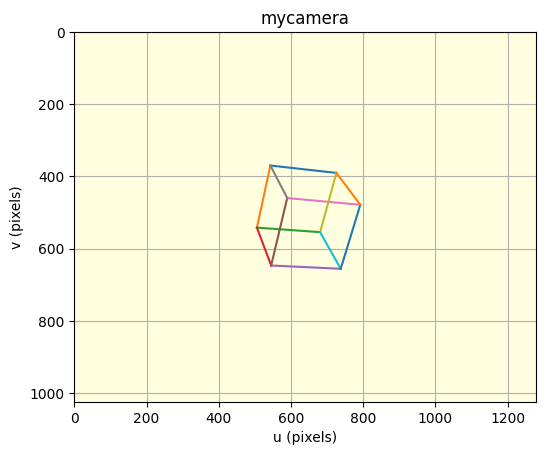

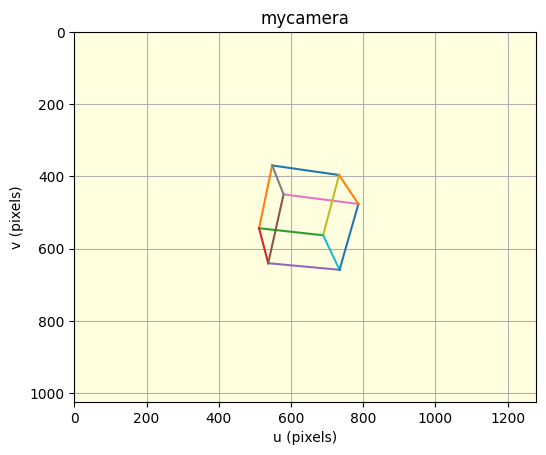

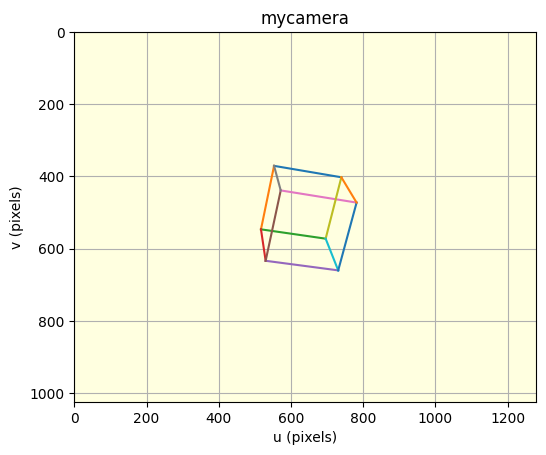

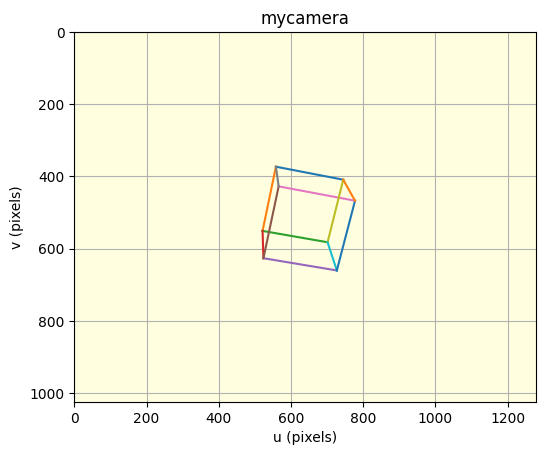

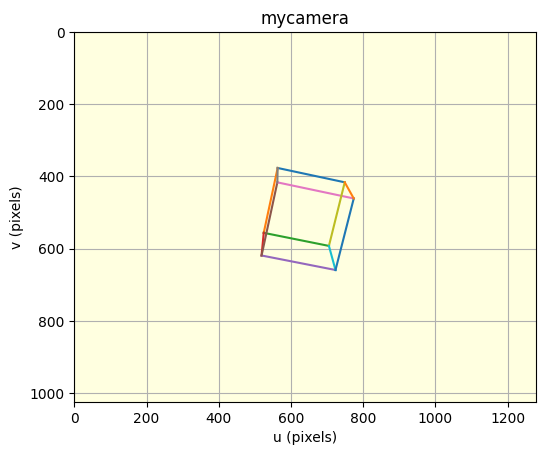

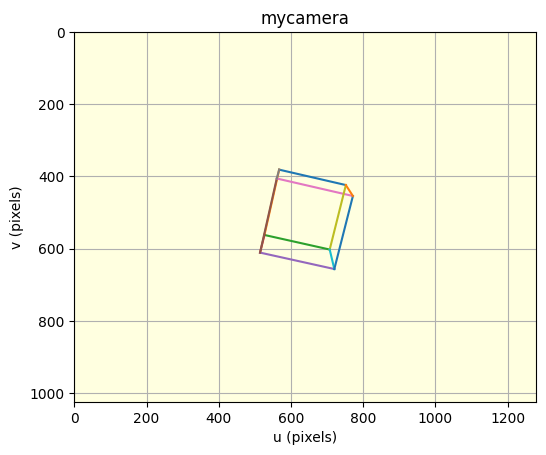

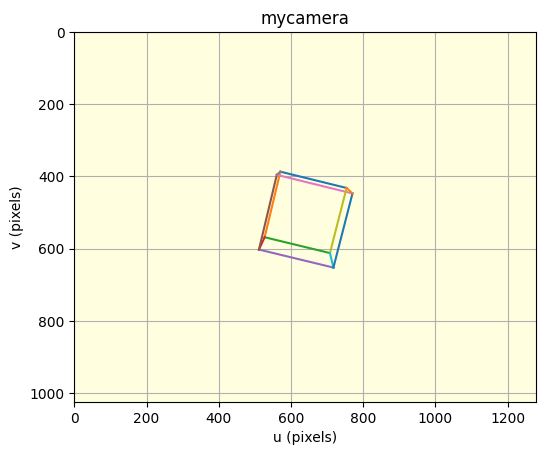

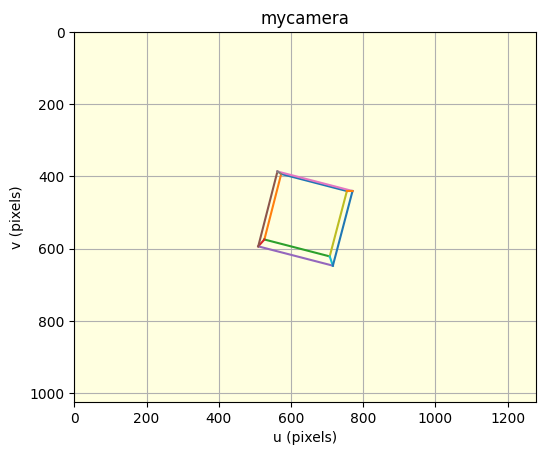

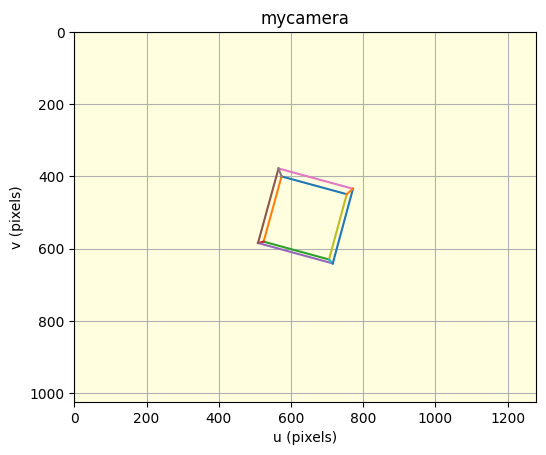

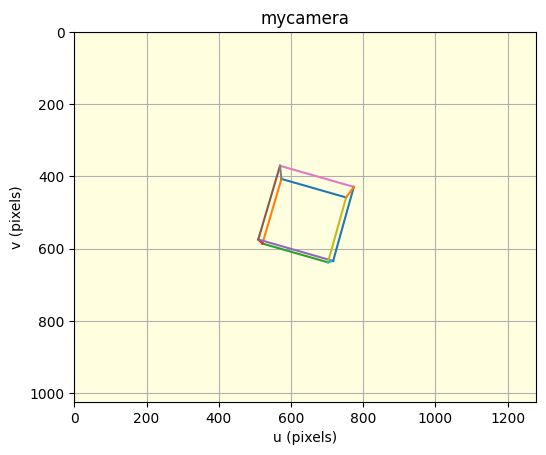

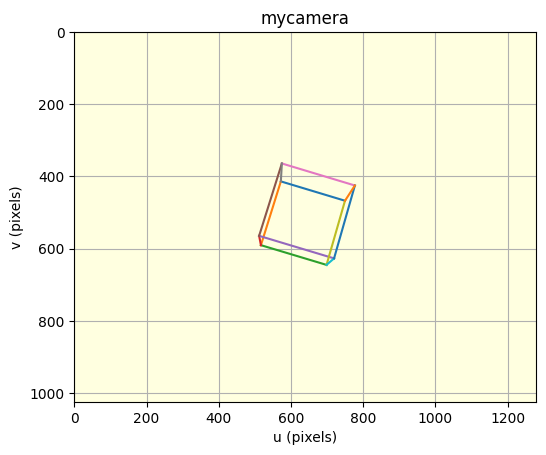

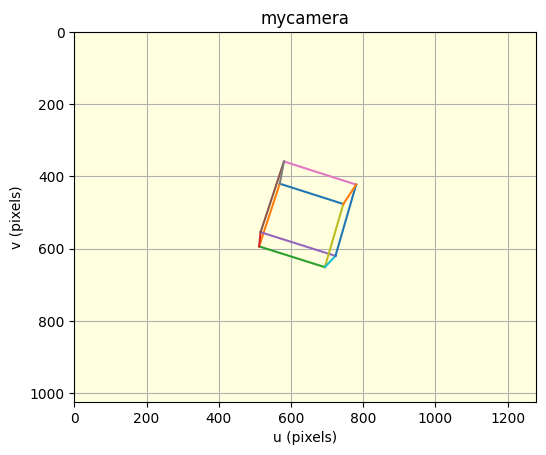

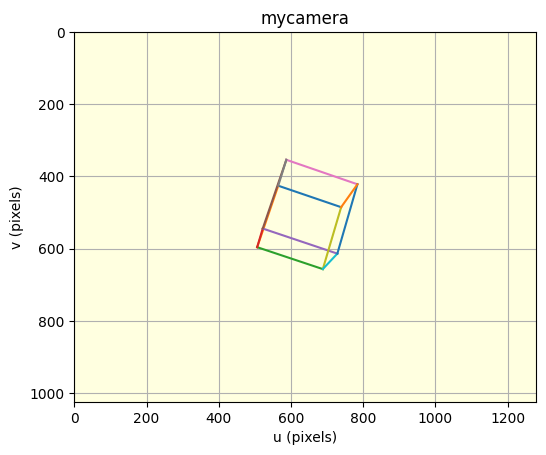

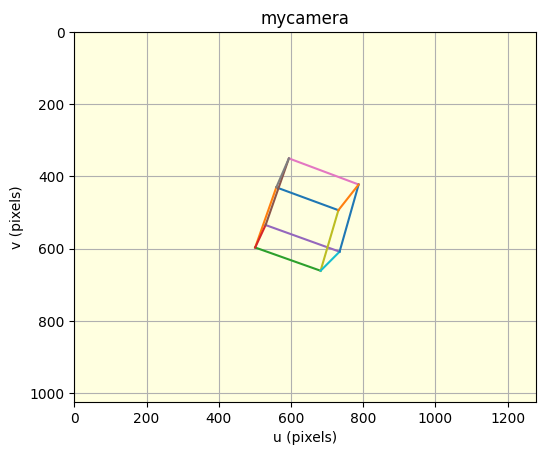

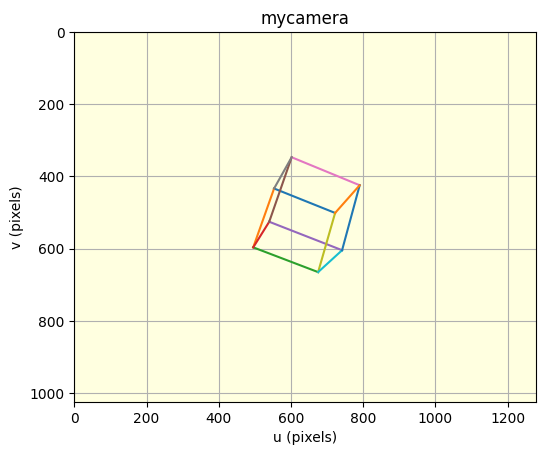

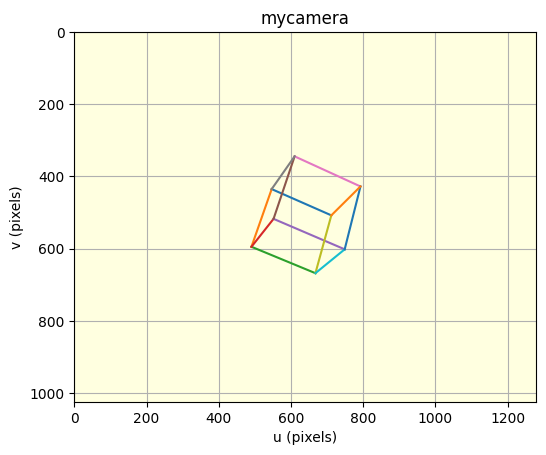

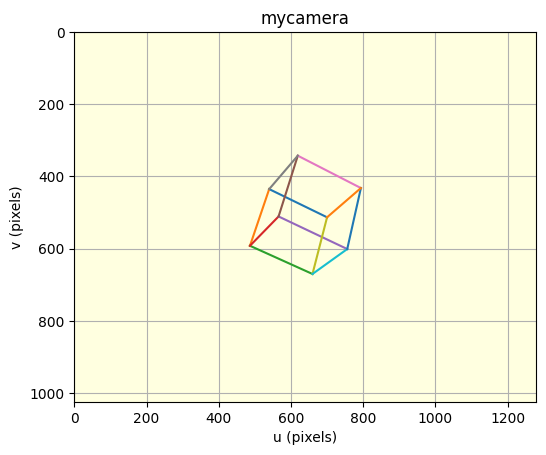

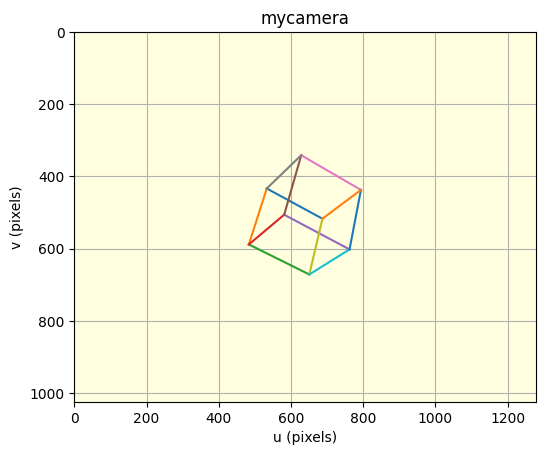

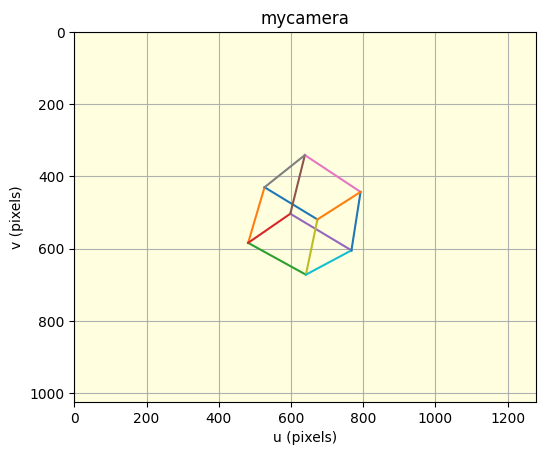

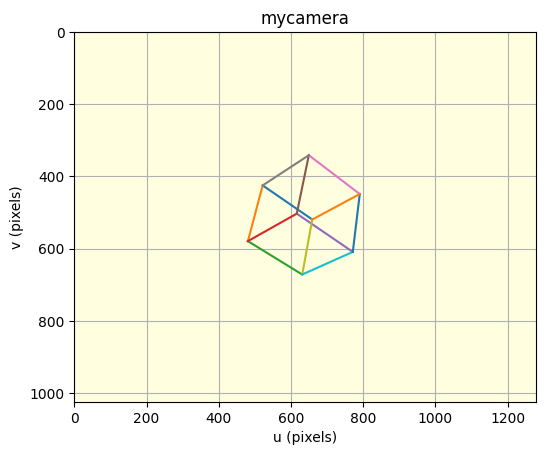

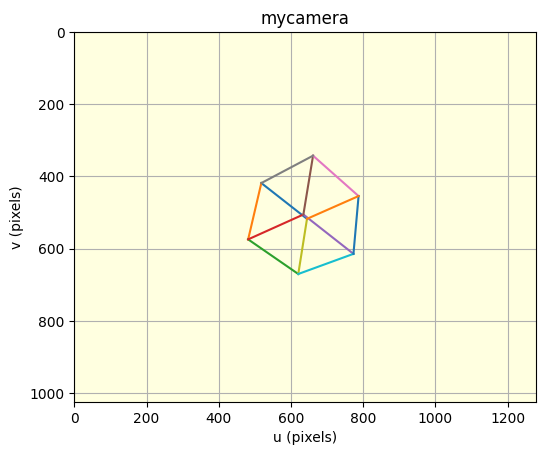

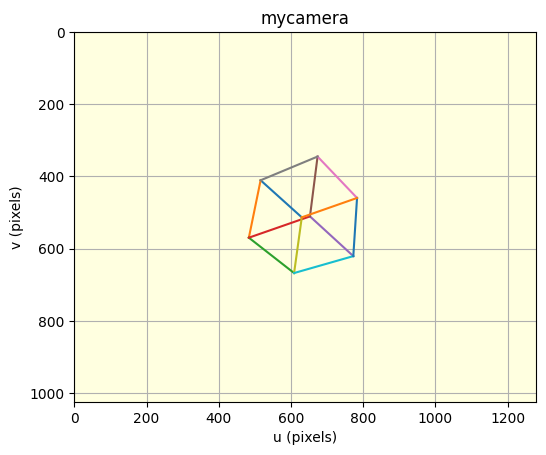

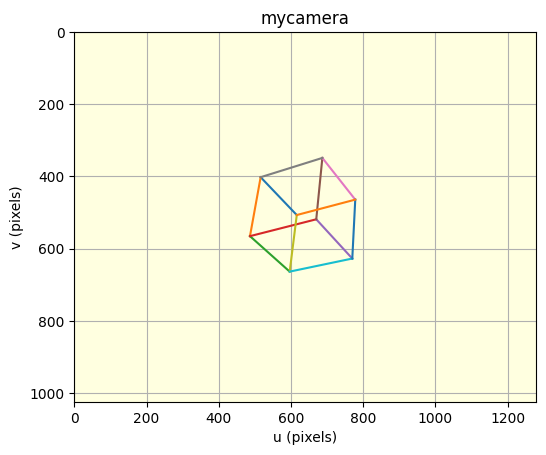

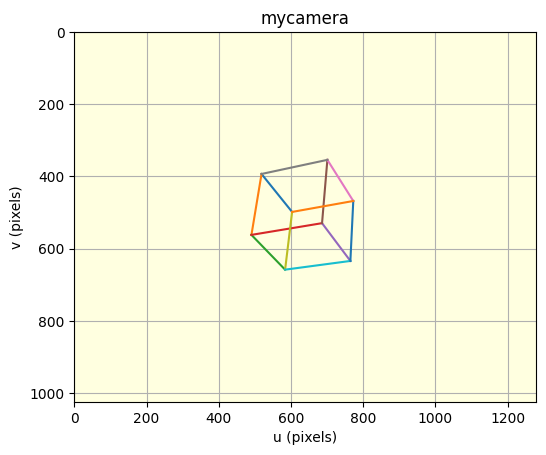

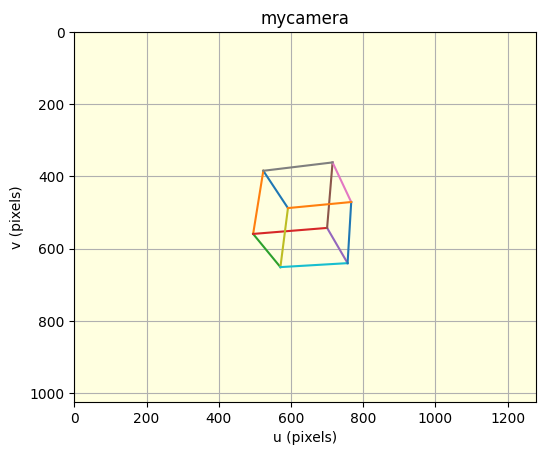

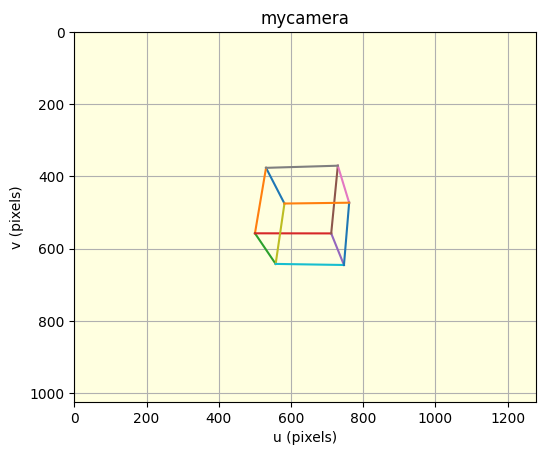

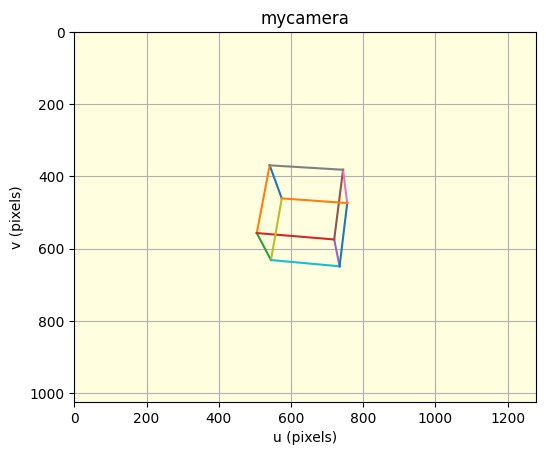

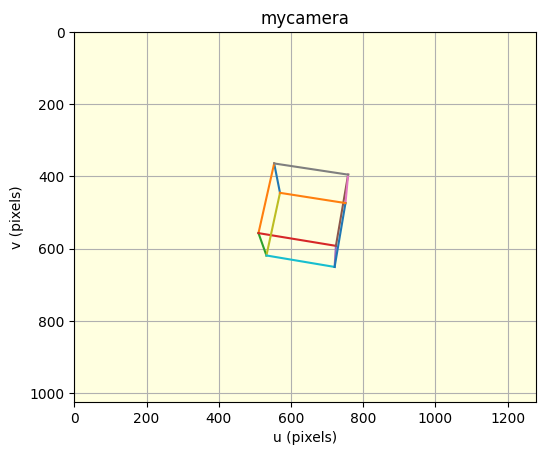

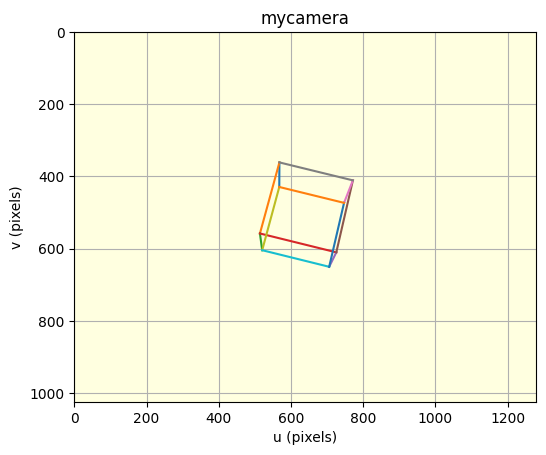

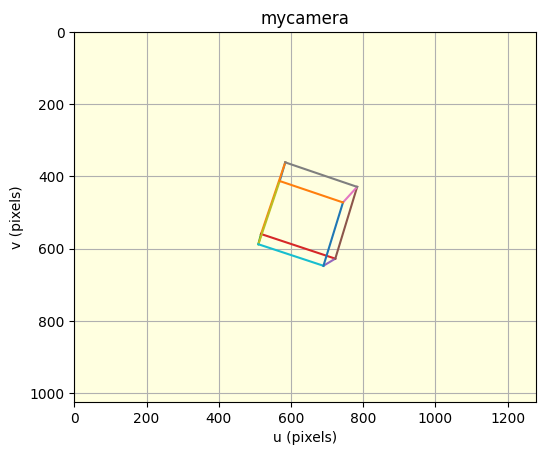

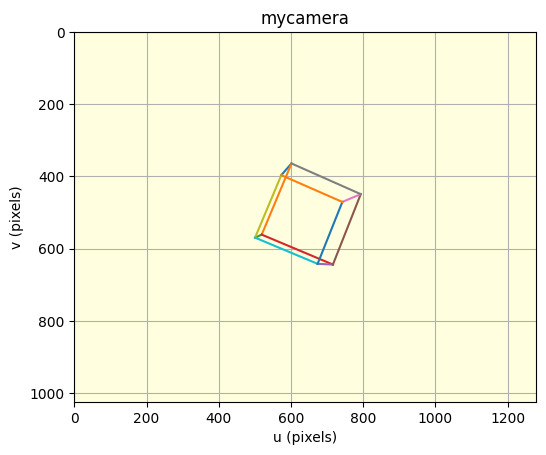

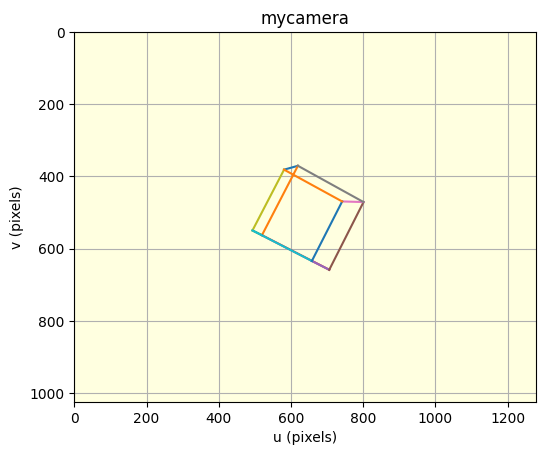

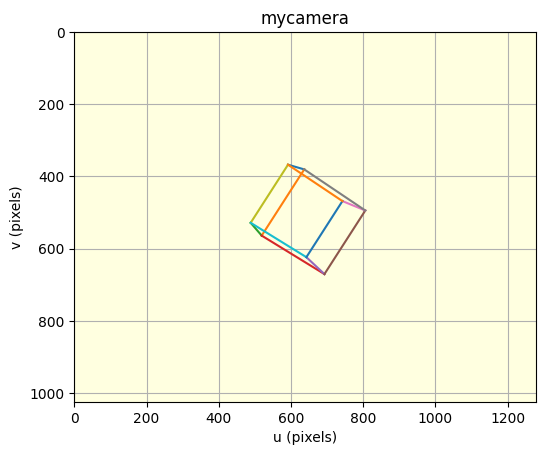

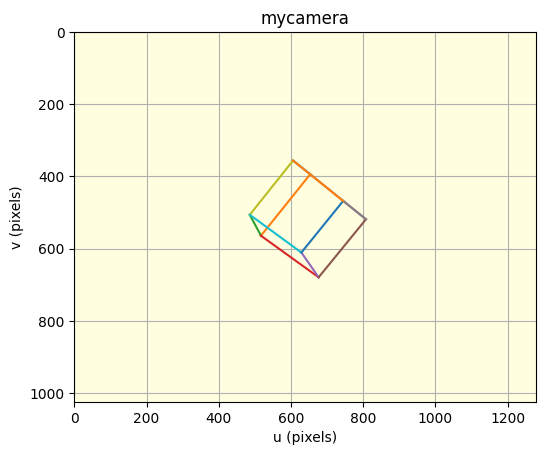

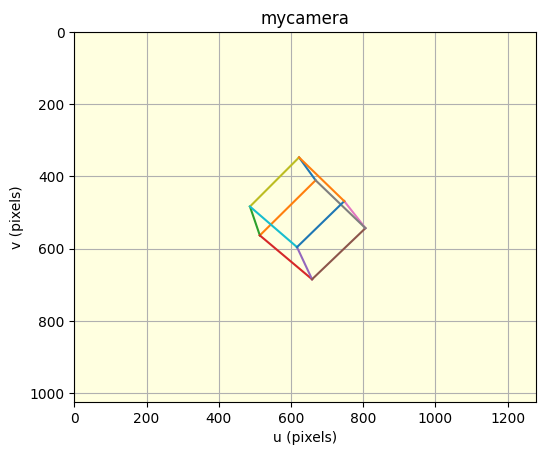

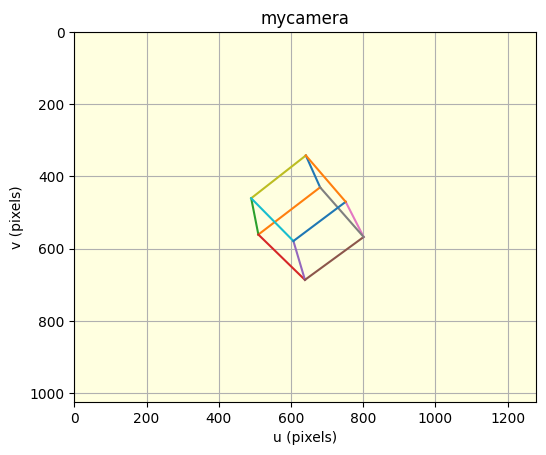

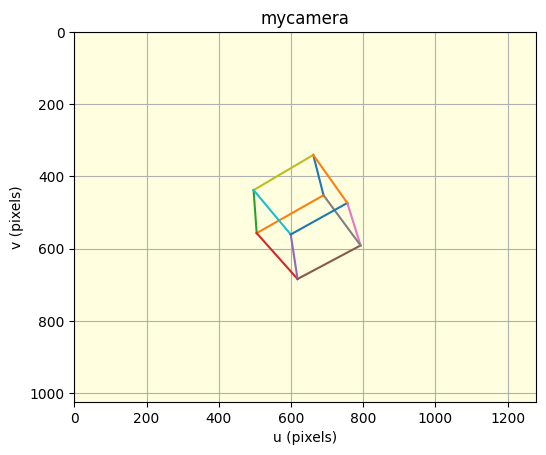

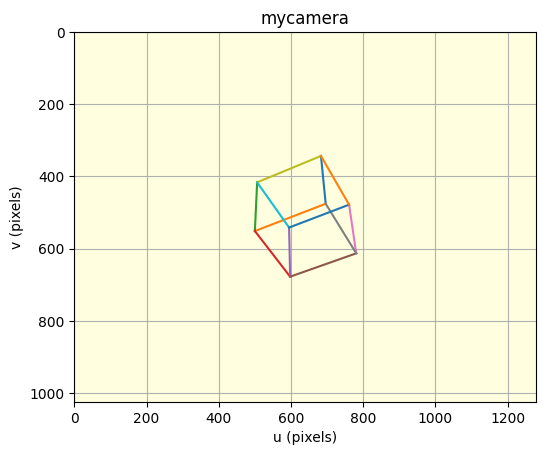

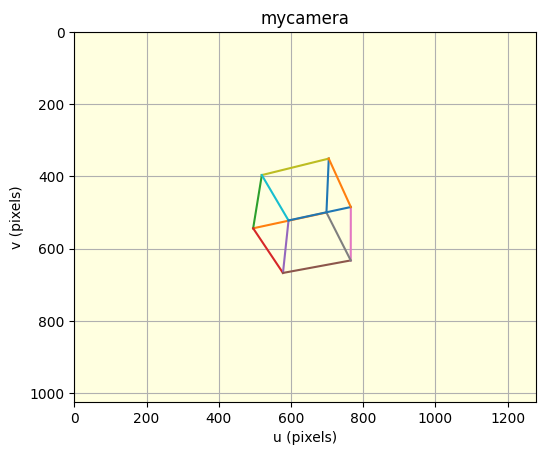

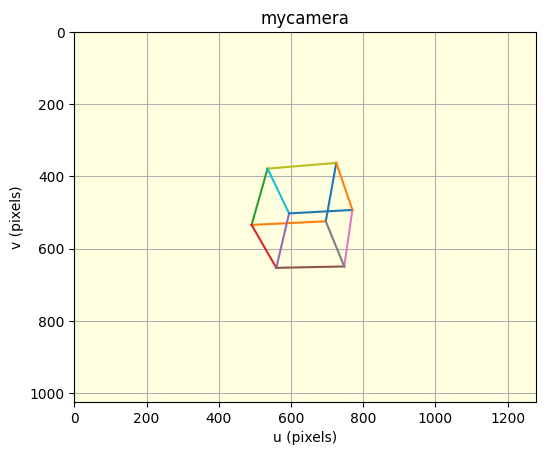

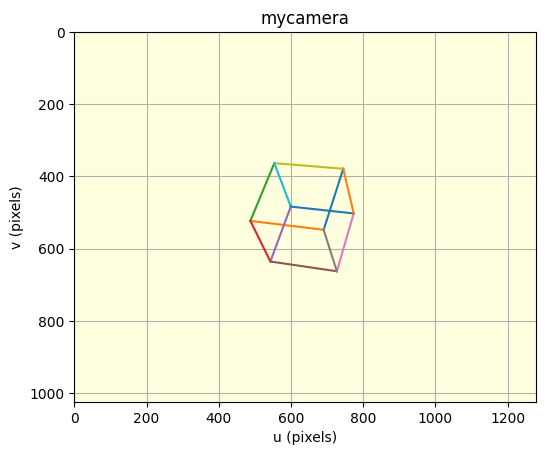

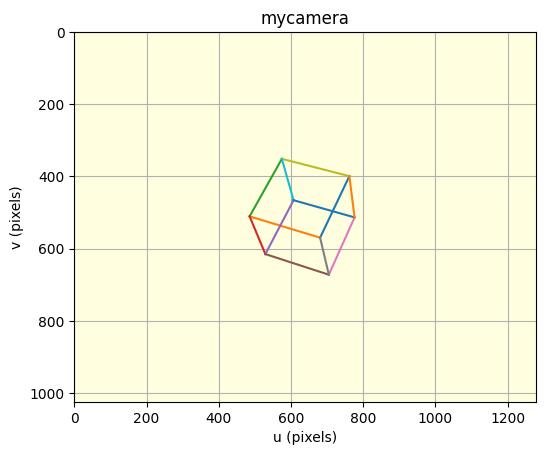

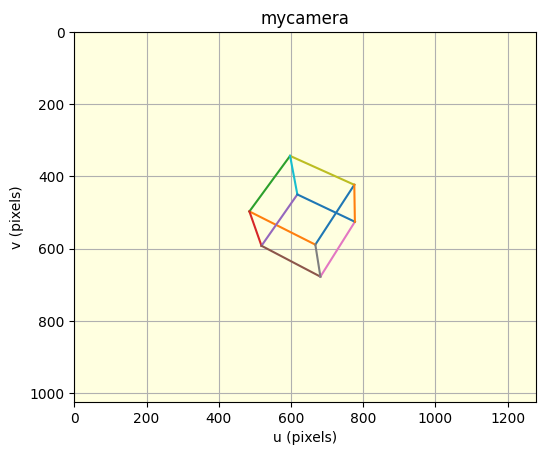

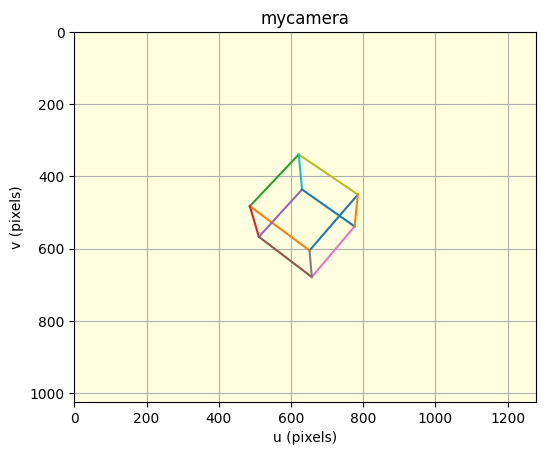

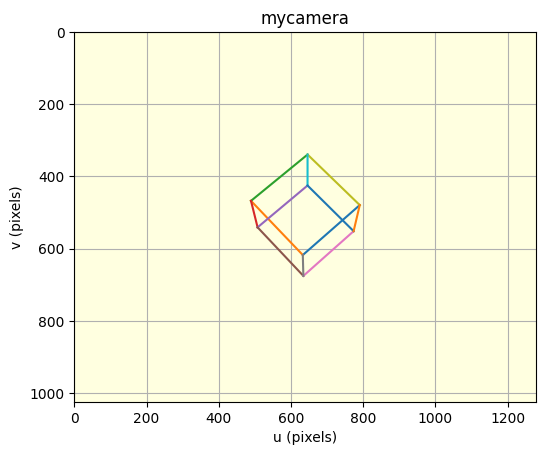

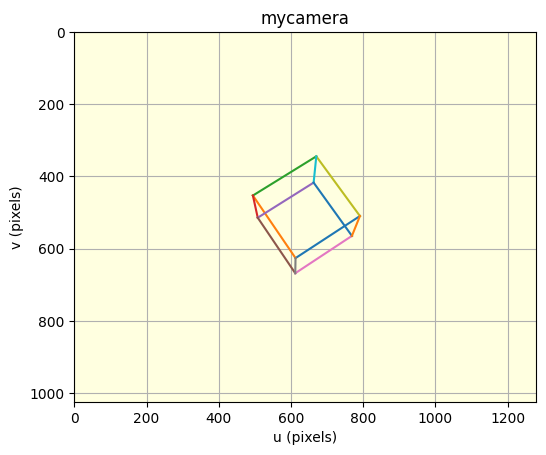

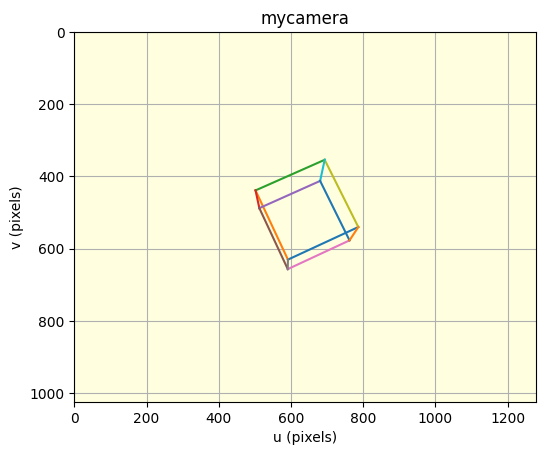

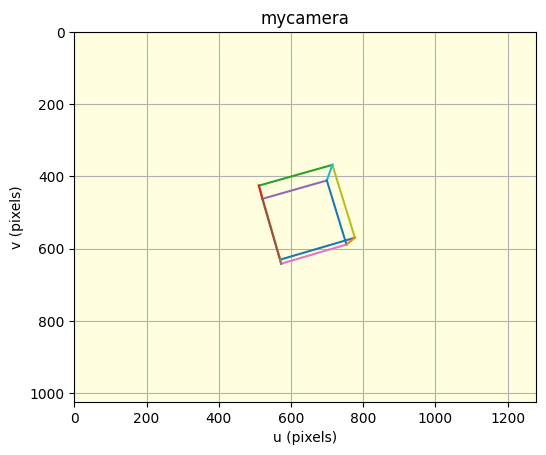

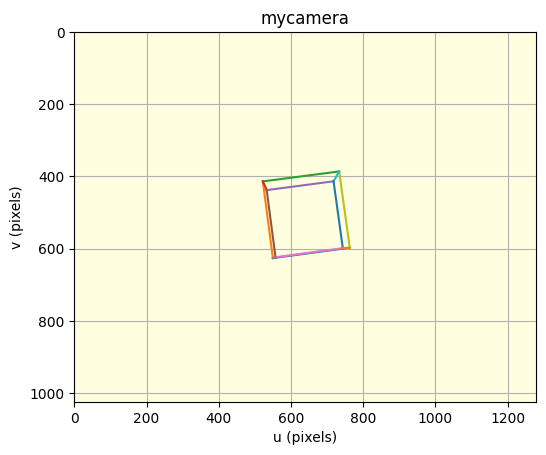

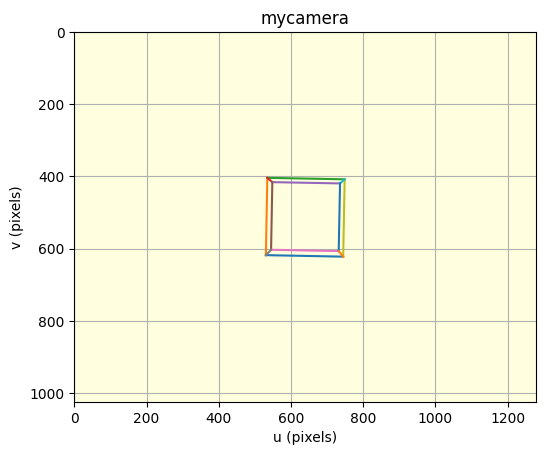

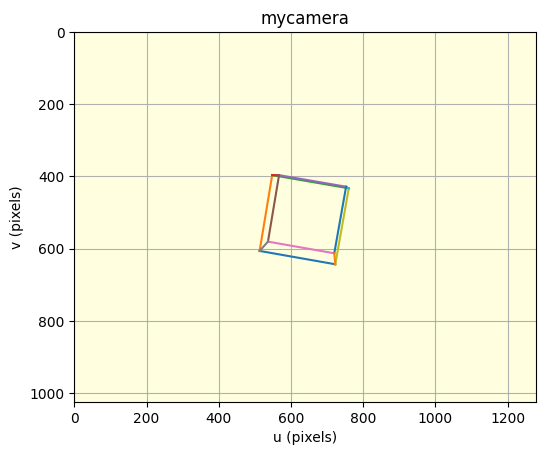

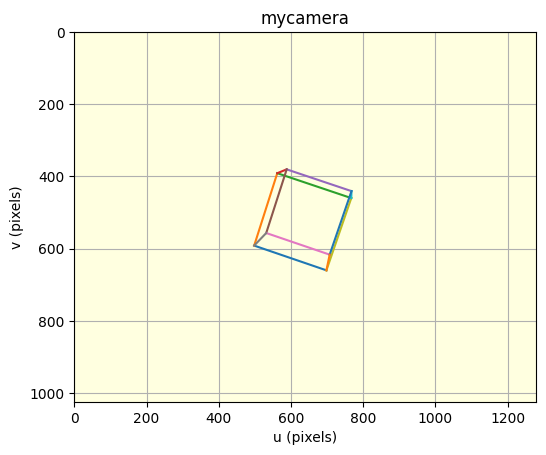

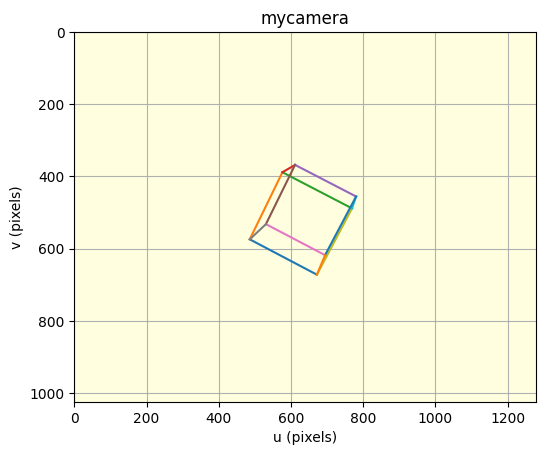

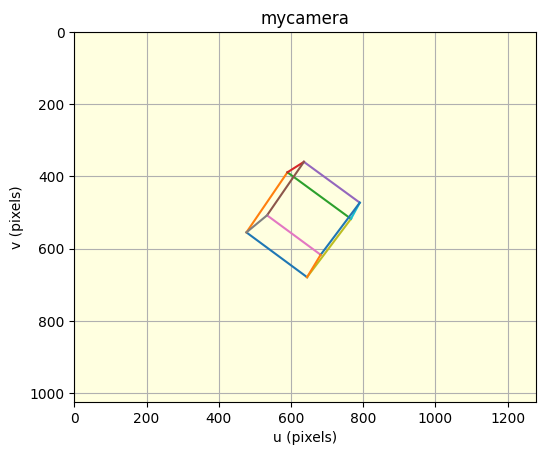

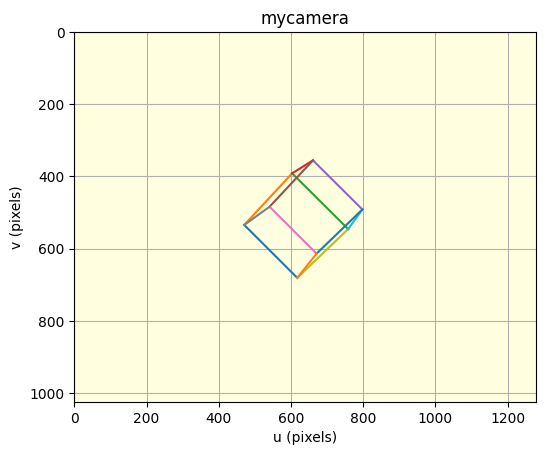

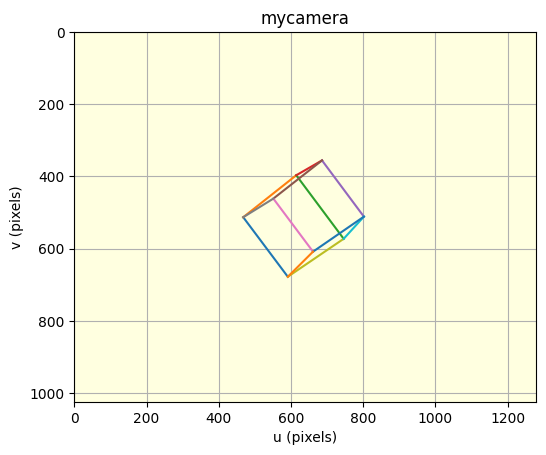

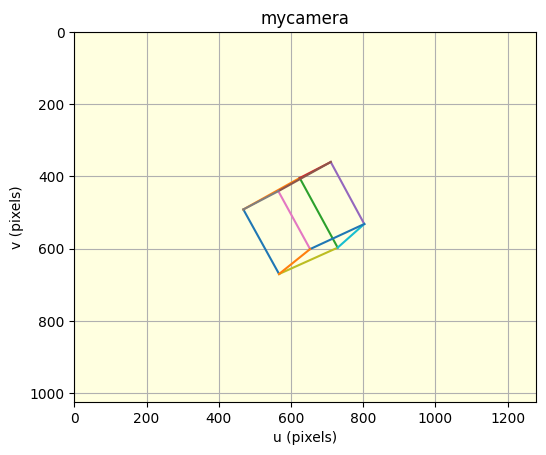

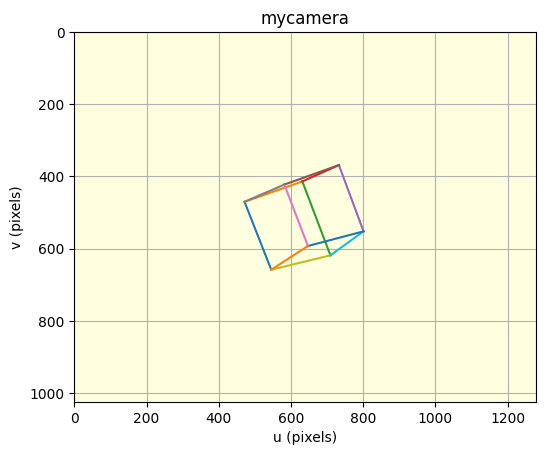

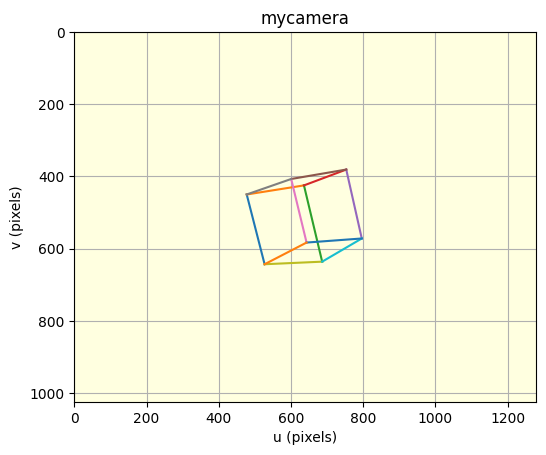

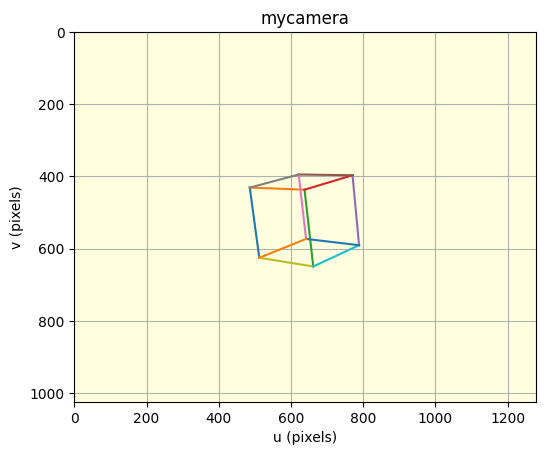

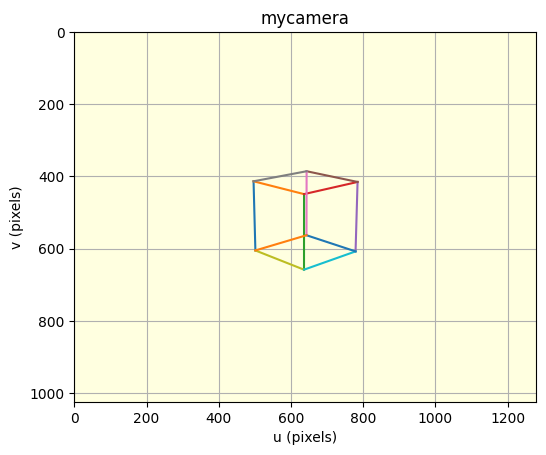

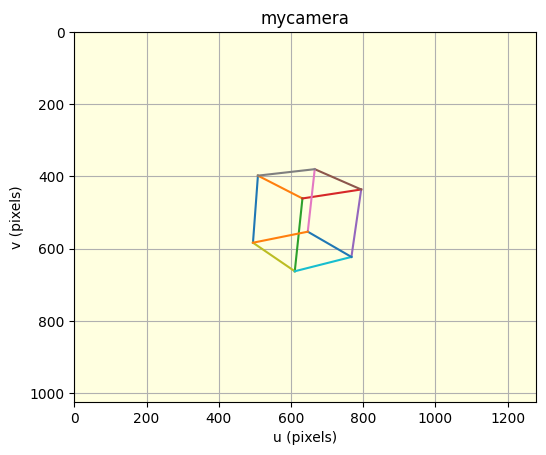

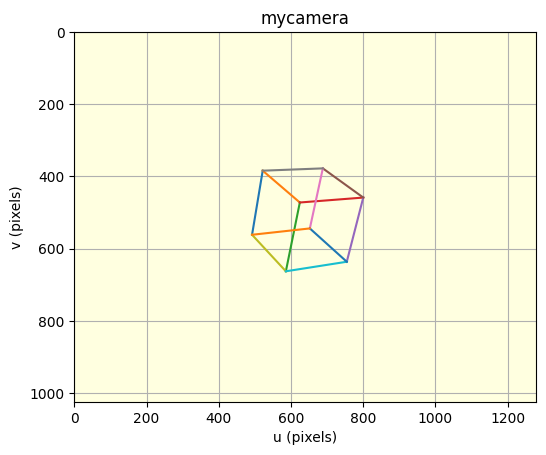

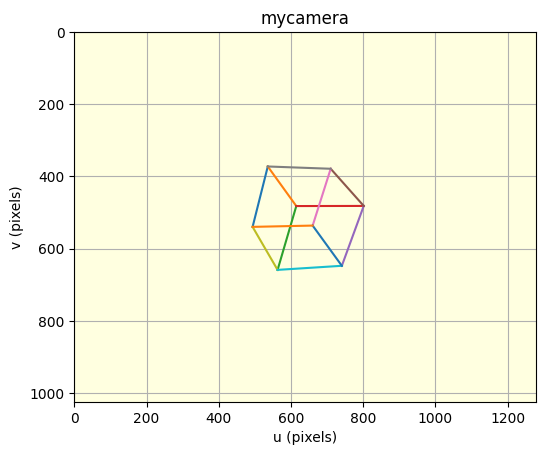

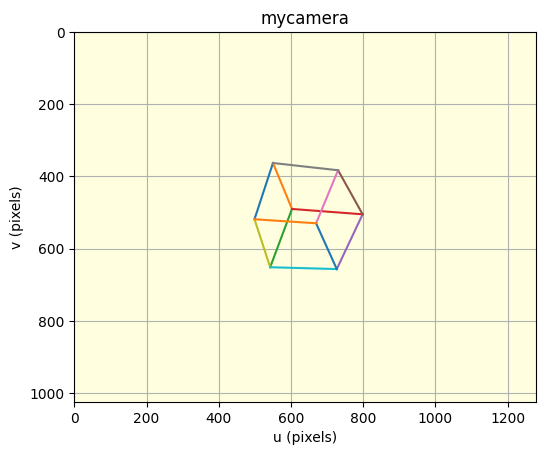

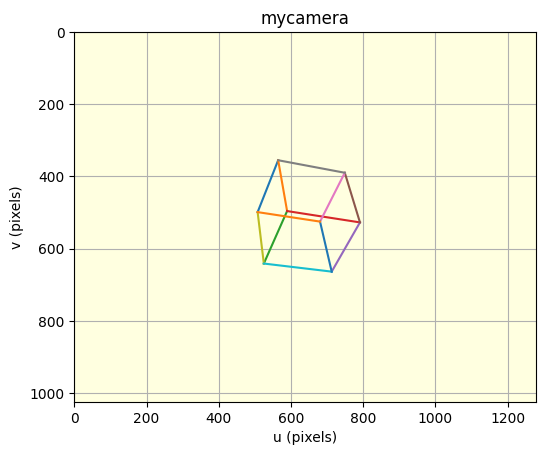

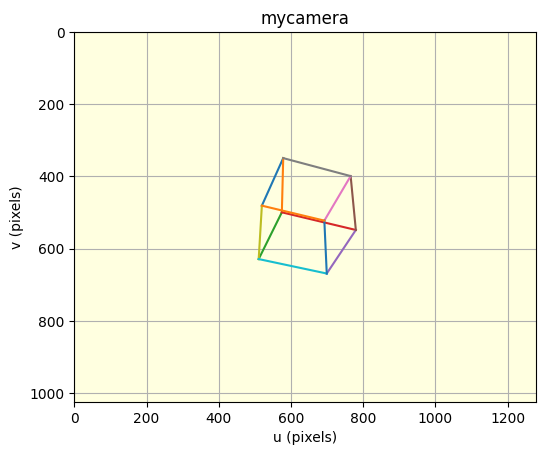

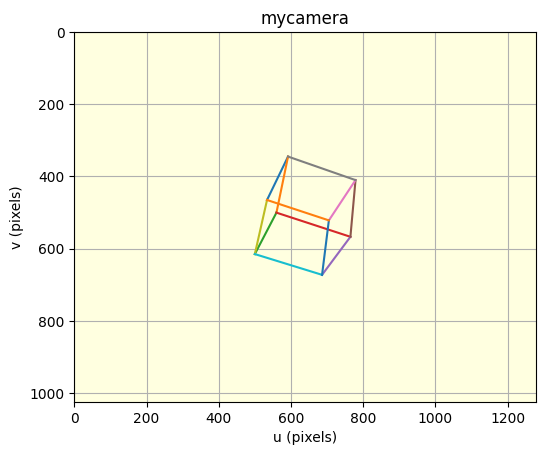

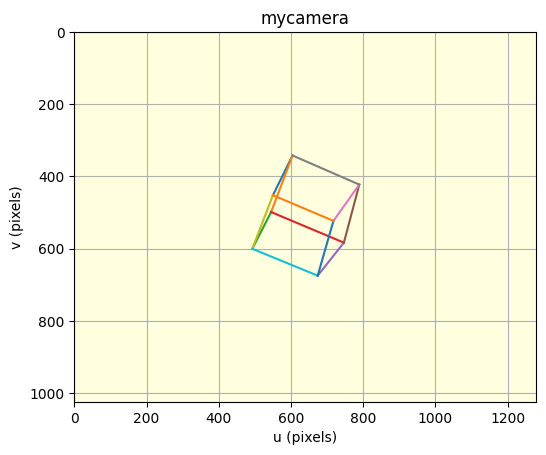

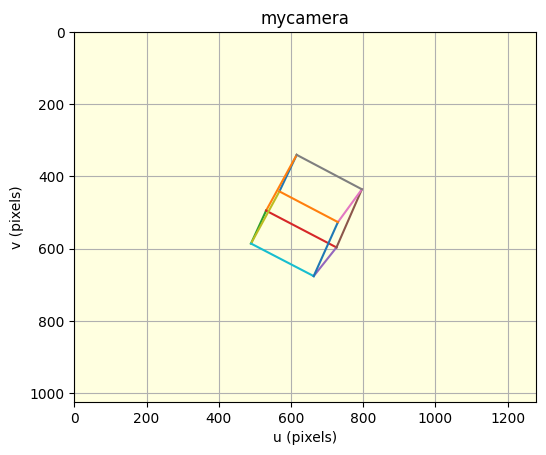

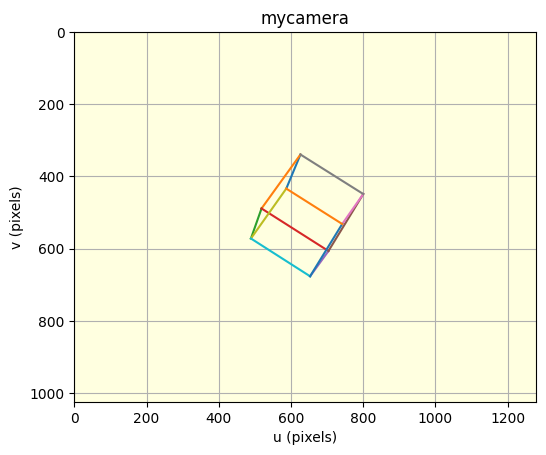

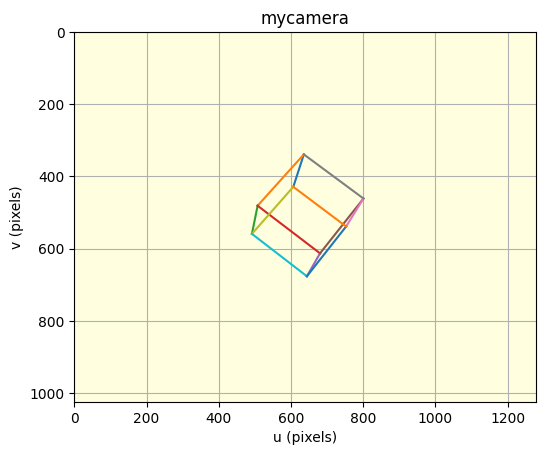

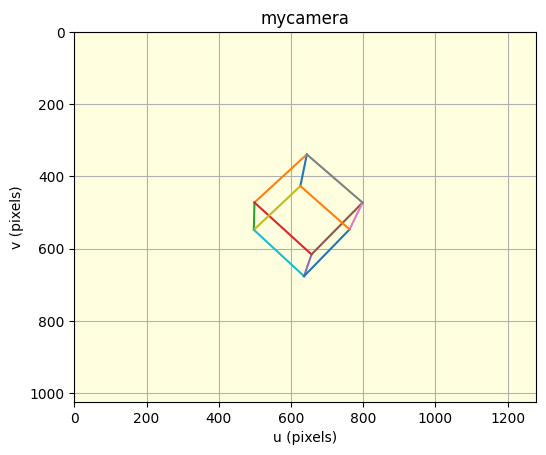

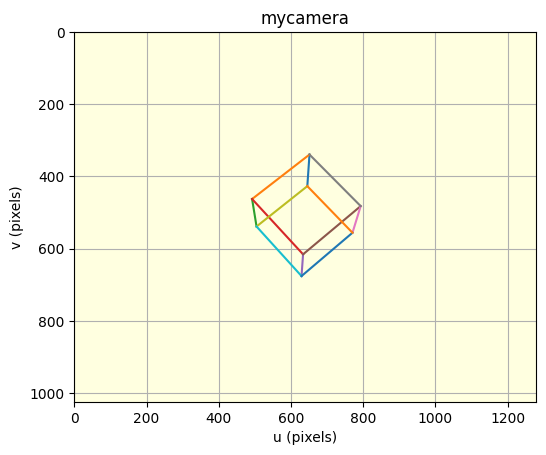

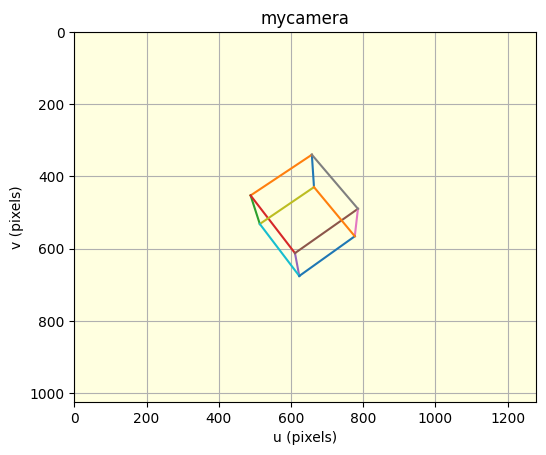

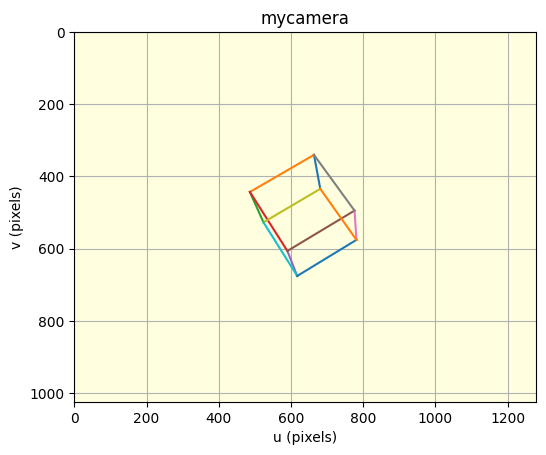

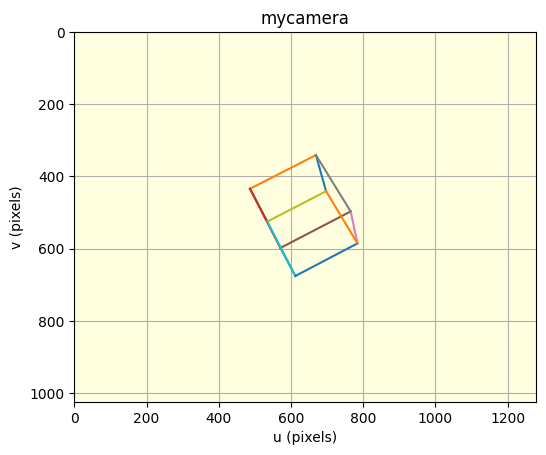

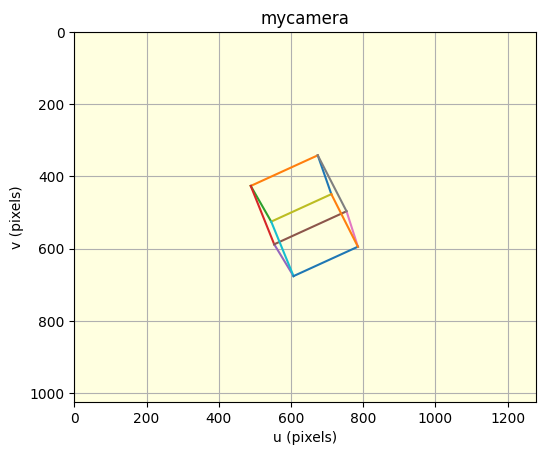

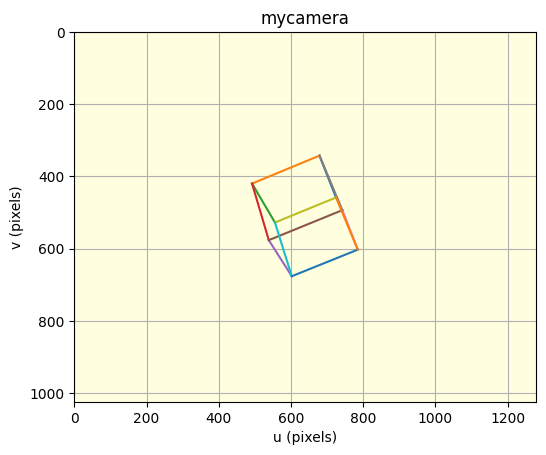

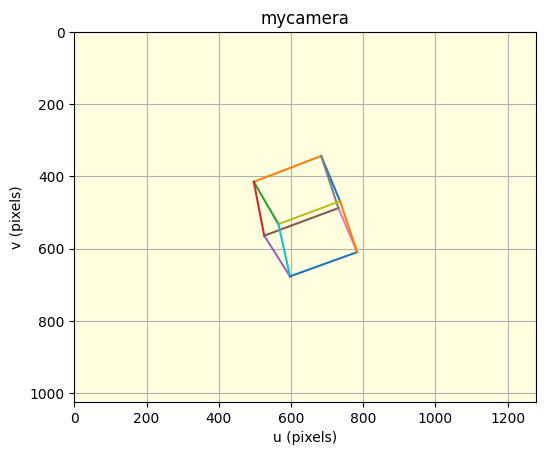

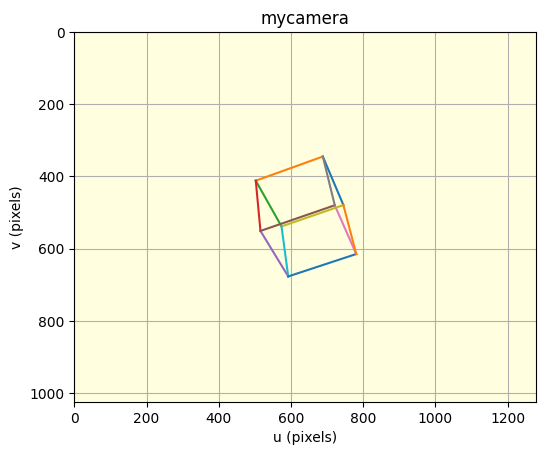

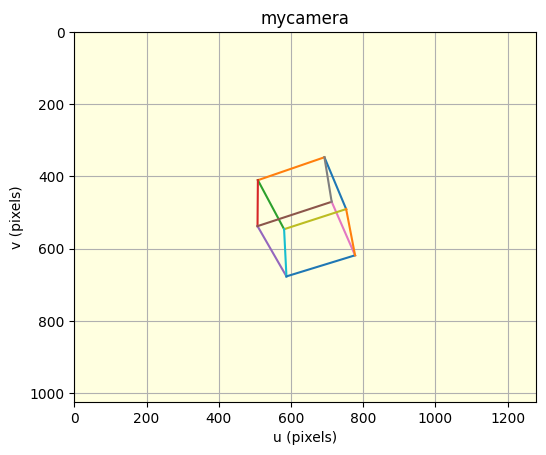

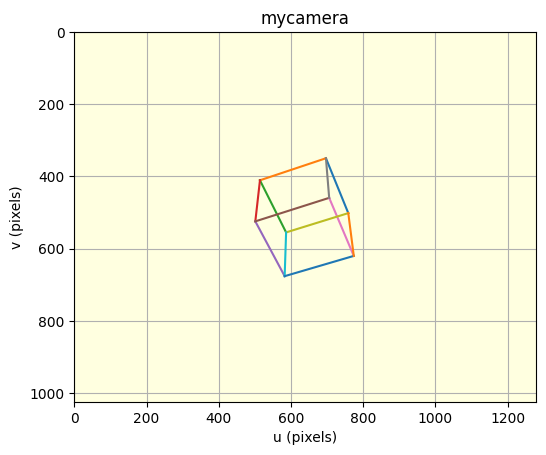

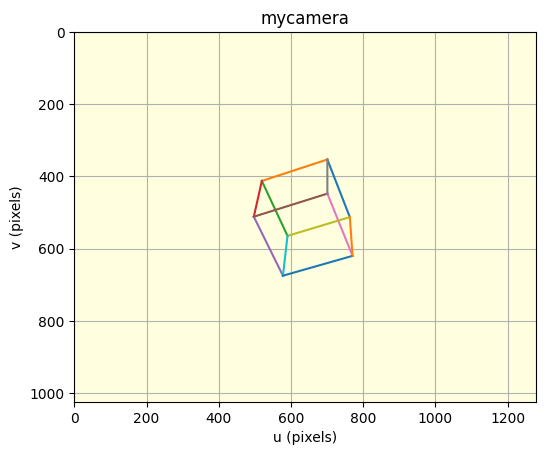

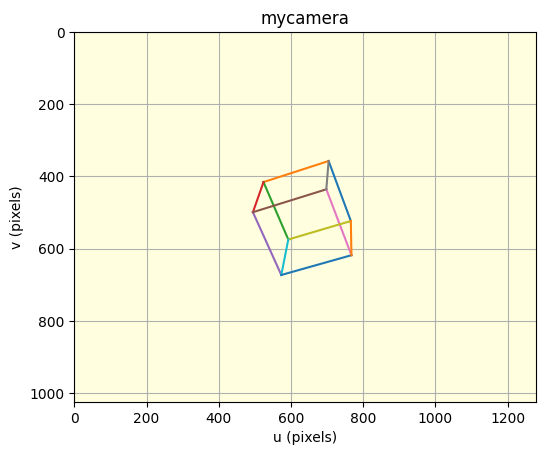

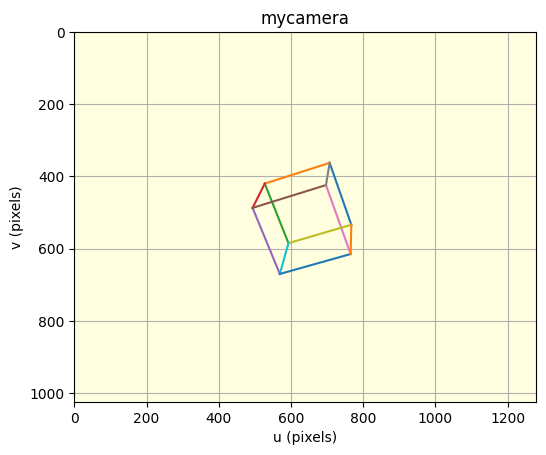

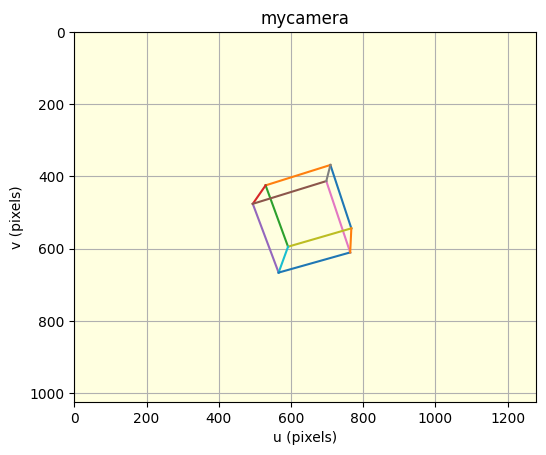

t = -0.000106, -0.000605, -0.00303; rpy/yxz = -0.0159°, -0.0615°, 0.0872°
t = 0.1, 0.2, 1.5; rpy/zyx = 5.73°, 11.5°, 17.2°
t = 0.1, 0.2, 1.5; rpy/zyx = 5.77°, 11.5°, 17.2°


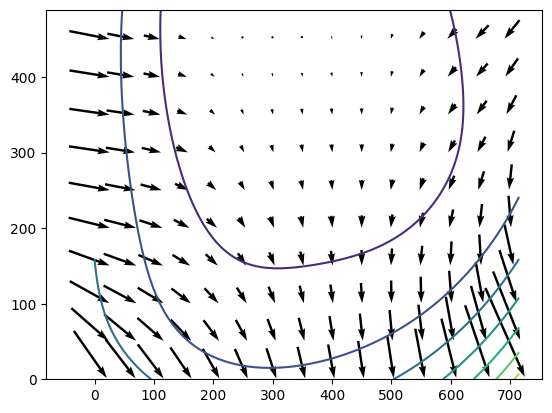

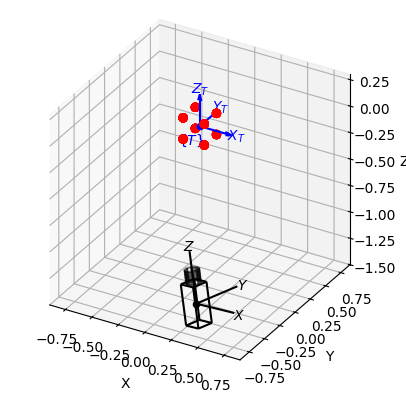

In [23]:
# ------ standard imports ------ #

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})

np.random.seed(0)

from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

# ------------------------------ #

# # 13.1 Perspective Camera
# ## 13.1.1 Perspective Projection
# ## 13.1.2 Modeling a Perspective Camera
#

camera = CentralCamera(f=0.015);

P = [0.3, 0.4, 3.0];

camera.project_point(P)

camera.project_point(P, pose=SE3.Tx(-0.5))

# ## 13.1.3 Discrete Image Plane
#

camera = CentralCamera(f=0.015, rho=10e-6,
 imagesize=[1280, 1024], pp=[640, 512], name="mycamera")

camera.project_point(P)

# ## 13.1.4 Camera Matrix
#

camera.K

camera.C()

np.rad2deg(camera.fov())

P = np.column_stack([[0, 0, 10], [10, 10, 10]])
p, visible = camera.project_point(P, visibility=True)
visible

# ## 13.1.5 Projecting Points
#

P = mkgrid(n=3, side=0.2, pose=SE3.Tz(1.0));
P.shape

P[:, :4]

camera.project_point(P)

camera.plot_point(P);

T_camera = SE3.Trans(-1, 0, 0.5) * SE3.Ry(0.9);

camera.plot_point(P, pose=T_camera);

camera.project_point([1, 0, 0, 0], pose=T_camera)

camera.clf()  # clear the virtual image plane
p = camera.plot_point(P, pose=T_camera)

cube = mkcube(0.2, pose=SE3.Tz(1));
cube.shape

camera.clf()  # clear the virtual image plane
camera.plot_point(cube);

X, Y, Z = mkcube(0.2, pose=SE3.Tz(1), edge=True)
X.shape

camera.plot_wireframe(X, Y, Z)

camera.clf()  # clear the virtual image plane
camera.plot_wireframe(X, Y, Z, pose=T_camera);

X, Y, Z = mkcube(0.2, edge=True)
for theta in np.linspace(0, 2 * pi, 100):
  T_cube = SE3.Tz(1.5) * SE3.RPY(theta * np.array([1.1, 1.2, 1.3]))
  camera.clf()
  camera.plot_wireframe(X, Y, Z, objpose=T_cube)
  plt.pause(0.1)

## 13.1.6 Lens Distortion


# camera = CentralCamera(f=0.015, rho=10e-6,
#   imagesize=[1280, 1024], pp=[512, 512],
#   distortion=[k1, k2, k3, p1, p2])

# 13.2 Camera Calibration
## 13.2.1 Calibrating with a 3D Target


P = mkcube(0.2);

T_unknown = SE3.Trans(0.1, 0.2, 1.5) * SE3.RPY(0.1, 0.2, 0.3);

camera_unknown = CentralCamera(f=0.015, rho=10e-6, imagesize=[1280, 1024], noise=0.05, seed=0)

p = camera_unknown.project_point(P, objpose=T_unknown);

C, resid = CentralCamera.points2C(P, p)
C

resid

# ## 13.2.2 Calibrating with a Checkerboard
#

#images = ImageCollection("calibration/*.jpg");
images = ImageCollection("/home/andrew/ros2_ws/checkerboard_pics/*.jpg");
len(images)
K, distortion, frames = CentralCamera.images2C(images, gridshape=(7,6), squaresize=25e-3)

K

images[0].centre

for frame in frames:
  CentralCamera.plot(pose=frame.pose, scale=0.05)

distortion

# ### 13.2.2.1 Correcting for Lens Distortion
#

u0 = K[0, 2]; v0 = K[1, 2]; fpix_u = K[0, 0]; fpix_v = K[1,1];
k1, k2, p1, p2, k3 = distortion;

U, V = images[12].meshgrid()

u = (U - u0) / fpix_u;
v = (V - v0) / fpix_v;

r = np.sqrt(u**2 + v**2);

delta_u = u * (k1*r**2 + k2*r**4 + k3*r**6) + p1*u*v + p2*(r**2 + 2*u**2);
delta_v = v * (k1*r**2 + k2*r**4 + k3*r**6) + p1*(r**2 + 2*v**2) + p2*u*v;

ud = u + delta_u; vd = v + delta_v;

Ud = ud * fpix_u + u0;
Vd = vd * fpix_v + v0;

undistorted = images[12].warp(Ud, Vd)

plt.clf()   # clear 3D plot
plt.quiver(Ud[::50, ::50], Vd[::50, ::50], -delta_u[::50, ::50], -delta_v[::50, ::50]);

magnitude = np.sqrt(delta_u**2 + delta_v**2);
plt.contour(U, V, magnitude);

# ## 13.2.3 Decomposing the Camera Calibration Matrix
o = sp.linalg.null_space(C);
o.T

h2e(o).T

T_unknown.inv().t

est = CentralCamera.decomposeC(C)

est.f / est.rho[0]

camera.f / camera.rho[0]

(T_unknown * est.pose).printline(orient="camera")

plotvol3([-0.9, 0.9, -0.9, 0.9, -1.5, 0.3]);
plot_sphere(0.03, P, color="r");
SE3().plot(frame="T", color="b", length=0.3);

est.plot(scale=0.3, color="black", frame=True);

# ## 13.2.4 Pose Estimation with a Calibrated Camera
#

camera_calib = CentralCamera.Default(noise=0.1, seed=0);

P = mkcube(0.2);

T_unknown = SE3.Trans(0.1, 0.2, 1.5) * SE3.RPY(0.1, 0.2, 0.3);
T_unknown.printline()

p = camera_calib.project_point(P, objpose=T_unknown);

T_est = camera_calib.estpose(P, p).printline()

# # # 13.3 Wide Field-of-View Cameras
# # ## 13.3.1 Fisheye Lens Camera
# #

# camera = FishEyeCamera(
#           projection="equiangular",
#           rho=10e-6,
#           imagesize=[1280, 1024]
#           );

# X, Y, Z = mkcube(side=1, centre=[1, 1, 0.8], edge=True);

# camera.plot_wireframe(X, Y, Z, color="k");

# # ## 13.3.2 Catadioptric Camera
# #

# camera = CatadioptricCamera(
#           projection="equiangular",
#           rho=10e-6,
#           imagesize=[1280, 1024],
#           maxangle=pi/4
#       );

# X, Y, Z = mkcube(1, centre=[1, 1, 0.8], edge=True)

# camera.plot_wireframe(X, Y, Z, color="k");

# # ## 13.3.3 Spherical Camera
# #

# camera = SphericalCamera()

# X, Y, Z = mkcube(1, centre=[2, 3, 1], edge=True)

# camera.plot_wireframe(X, Y, Z, color="k");

# # # 13.4 Unified Imaging Model
# # ## 13.4.1 Mapping Wide-Angle Images to the Sphere
# #

# u0 = 528.1214; v0 = 384.0784; l = 2.7899; m = 996.4617;

# fisheye = Image.Read("fisheye_target.png", dtype="float", mono=True)

# n = 500;
# phi_range = np.linspace(-pi, pi, n);  # longitude
# theta_range = np.linspace(0, pi, n);     # colatitude
# Phi, Theta = np.meshgrid(phi_range, theta_range);

# r = (l + m) * np.sin(Theta) / (l - np.cos(Theta));

# U = r * np.cos(Phi) + u0;
# V = r * np.sin(Phi) + v0;

# spherical = fisheye.warp(U, V, domain=(phi_range, theta_range))

# spherical.disp(axes=("$\phi$", "$\theta$"));

# ax = plotvol3();
# plot_sphere(radius=1, ax=ax, filled=True, resolution=n,
#   facecolors=spherical.colorize().A, cstride=1, rstride=1);

# # ## 13.4.2 Mapping from the Sphere to a Perspective Image
# #

# W = 1000;
# m = W / 2 / np.tan(np.deg2rad(45 / 2))

# l = 0;

# u0, v0 = W / 2, W / 2;

# U, V = Image.meshgrid(width=W, height=W);

# U0 = U - u0; V0 = V - v0;
# r = np.sqrt(U0**2 + V0**2);
# phi = np.arctan2(V0, U0);

# Phi = phi;
# Theta = pi - np.arctan(r / m);

# spherical.warp(Phi, Theta).disp();

# spherical2 = spherical.rotate_spherical(SO3.Ry(0.9) * SO3.Rz(-1.5))

# spherical2.warp(Phi, Theta).disp();

# # # 13.6 Applications
# # ## 13.6.1 Fiducial Markers
# #

# scene = Image.Read("lab-scene.png", rgb=False)
# scene.disp();

# camera = CentralCamera(f=3045, imagesize=scene.shape, 
#                        pp=(2016, 1512), rho=1.4e-6);

# markers = scene.fiducial(dict="4x4_50", K=camera.K, side=67e-3);

# markers[2]

# markers[2].corners

# for marker in markers:
#   marker.draw(scene, length=0.10, thick=20)

# # ## 13.6.2 Planar Homography
# #

# T_camera = SE3.Tz(8) * SE3.Rx(-2.8);
# camera = CentralCamera.Default(f=0.012, pose=T_camera);

# P = np.column_stack([[-1, 1], [-1, 2], [2, 2], [2, 1]])

# camera.project_point(np.vstack([P, np.zeros((4,))]))

# H = np.delete(camera.C(), 2, axis=1)

# homtrans(H, P)

# p = np.column_stack([[0, 0], [0, 1000], [1000, 1000], [1000, 0]])

# Pi = homtrans(np.linalg.inv(H), p)

# camera.plot(scale=2, color="black");
# plot_sphere(radius=0.1, centre=np.vstack((P, np.zeros((4,)))), color="red");
# plot_sphere(radius=0.1, centre=np.vstack((Pi, np.zeros((4,)))), color="blue");

# # # 13.7 Advanced Topics
# # ## 13.7.1 Projecting 3D Lines and Quadrics
# #

# L = Line3.Join((0, 0, 1), (1, 1, 1))

# L.w

# camera = CentralCamera.Default();
# l = camera.project_line(L)

# camera.plot_line2(l)

# camera.plot_line3(L)

# T_camera = pose=SE3.Trans(0.2, 0.1, -5) * SE3.Rx(0.2);
# camera = CentralCamera.Default(f=0.015, pose=T_camera);

# Q = np.diag([1, 1, 1, -1]);

# adj = lambda A: np.linalg.det(A) * np.linalg.inv(A);
# C = camera.C();
# c = adj(C @ adj(Q) @ C.T)

# np.linalg.det(c[:2, :2])

# from sympy import symbols, Matrix, Eq, plot_implicit
# x, y = symbols("x y")
# X = Matrix([[x, y, 1]]);
# ellipse = X * Matrix(c) * X.T;
# plot_implicit(Eq(ellipse[0], 1), (x, 0, 1_000), (y, 0, 1_000), );